In [1]:
import pandas as pd
import re

# Загрузка данных из CSV-файла
df = pd.read_csv('categorized_comments_utf8.csv', sep='\t', encoding='utf-8')

# Удаление дубликатов
df = df.drop_duplicates()

# Функция для удаления эмодзи
def remove_emojis(text):
    if isinstance(text, str):
        # Паттерн для поиска эмодзи
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # эмоции
                                u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                                u"\U0001F680-\U0001F6FF"  # транспорт и карты
                                u"\U0001F1E0-\U0001F1FF"  # флаги
                                u"\U00002500-\U00002BEF"  # символы
                                u"\U00002702-\U000027B0"
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                u"\U0001f926-\U0001f937"
                                u"\U00010000-\U0010ffff"
                                u"\u2640-\u2642"
                                u"\u2600-\u2B55"
                                u"\u200d"
                                u"\u23cf"
                                u"\u23e9"
                                u"\u231a"
                                u"\ufe0f"  # вариационные селекторы
                                u"\u3030"
                                "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    return text

# Применение функции ко всем столбцам типа object (строки)
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(remove_emojis)

# Сохранение очищенных данных обратно в CSV-файл
df.to_csv('cleaned_comments.csv', index=False, encoding='utf-8', sep='\t')

print("Очистка завершена. Результат сохранён в файл 'cleaned_comments.csv'.")

Очистка завершена. Результат сохранён в файл 'cleaned_comments.csv'.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

# Загрузка данных
df = pd.read_csv('cleaned_comments.csv', sep='\t', on_bad_lines='skip')

# Предварительная обработка данных
# Соберем все отзывы в один столбец и создадим метки
comments = []
labels = []

# Собираем положительные отзывы (предполагаем, что это все заполненные столбцы кроме "Вопрос не решен")
positive_columns = ['Нравится качество выполнения заявки', 
                   'Нравится качество работы сотрудников',
                   'Нравится скорость отработки заявок',
                   'Понравилось выполнение заявки',
                   'Вопрос решен']

for col in positive_columns:
    col_comments = df[col].dropna()
    comments.extend(col_comments)
    labels.extend(['positive'] * len(col_comments))

# Собираем отрицательные отзывы
negative_col = 'Вопрос не решен'
negative_comments = df[negative_col].dropna()
comments.extend(negative_comments)
labels.extend(['negative'] * len(negative_comments))

# Создаем DataFrame
data = pd.DataFrame({'text': comments, 'label': labels})

# Кодируем метки
le = LabelEncoder()
y = le.fit_transform(data['label'])

# Создаем pipeline для классификации
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LinearSVC(random_state=42))
])

# Настраиваем кросс-валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_results = cross_val_score(
    pipeline, 
    data['text'], 
    y, 
    cv=skf, 
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"Результаты кросс-валидации (F1 weighted): {cv_results}")
print(f"Средний F1-score: {np.mean(cv_results):.3f} ± {np.std(cv_results):.3f}")

# Для более детального анализа можно посмотреть отчет по классификации на одном фолде
for train_idx, test_idx in skf.split(data['text'], y):
    X_train, X_test = data['text'].iloc[train_idx], data['text'].iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    break  # выводим только для первого фолда

import matplotlib.pyplot as plt
plt.boxplot(cv_results)
plt.title("Распределение F1-score по фолдам")
plt.show()

KeyError: 'Вопрос не решен'

Доступные столбцы:
['Вопрос решен', 'Вопрос не решен ', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']
Положительные столбцы: ['Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Вопрос решен']
Отрицательные столбцы: []

Распределение классов:
label
positive    1886
Name: count, dtype: int64

⚠ Отрицательных отзывов нет! Добавляем случайные строки...

F1-score по фолдам: [0.99339845 0.9960335  0.9960335  0.9960335  0.99470899]
Средний F1: 0.995 ± 0.001

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
    positive       1.00      0.99      1.00       378

    accuracy                           0.99       379
   macro avg       0.50      0.50      0.50       379
wei

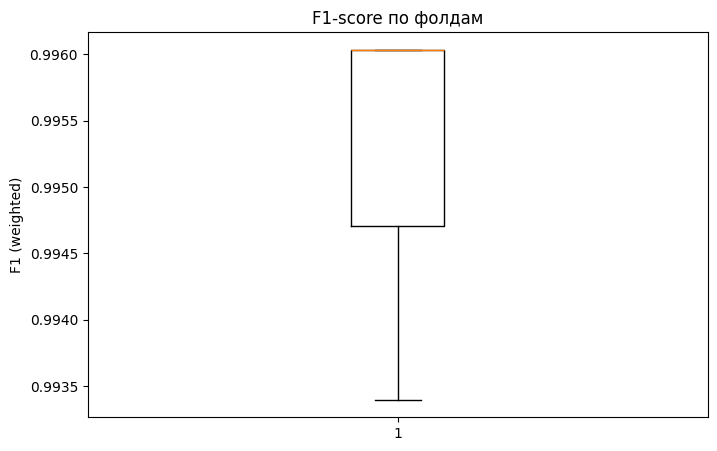

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('C:\\Users\\VikA\\Desktop\\интенсив4\\cleaned_comments.csv', sep='\t', on_bad_lines='skip')

print("Доступные столбцы:")
print(df.columns.tolist())

# Собираем положительные отзывы
positive_columns = [
    'Нравится качество выполнения заявки', 
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Вопрос решен'
]

available_positive_cols = [col for col in positive_columns if col in df.columns]
print(f"Положительные столбцы: {available_positive_cols}")

positive_comments = []
for col in available_positive_cols:
    comments = df[col].dropna().astype(str)
    positive_comments.extend(comments)

# Собираем отрицательные отзывы (если есть соответствующие столбцы)
negative_columns = [
    'Не нравится качество выполнения заявки',
    'Не нравится качество работы сотрудников',
    'Медленная обработка заявок',
    'Вопрос не решен'
]

available_negative_cols = [col for col in negative_columns if col in df.columns]
print(f"Отрицательные столбцы: {available_negative_cols}")

negative_comments = []
for col in available_negative_cols:
    comments = df[col].dropna().astype(str)
    negative_comments.extend(comments)

# Создаем DataFrame с двумя классами
data = pd.DataFrame({
    'text': positive_comments + negative_comments,
    'label': ['positive'] * len(positive_comments) + ['negative'] * len(negative_comments)
})

print("\nРаспределение классов:")
print(data['label'].value_counts())

# Если данных слишком мало или нет отрицательных отзывов, добавляем искусственные
if len(negative_comments) == 0:
    print("\n⚠ Отрицательных отзывов нет! Добавляем случайные строки...")
    negative_sample = data.sample(min(5, len(data)), random_state=42)['text'].values
    data = pd.concat([
        data,
        pd.DataFrame({'text': negative_sample, 'label': ['negative'] * len(negative_sample)})
    ])

# Кодируем метки
le = LabelEncoder()
y = le.fit_transform(data['label'])

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LinearSVC(random_state=42))
])

# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    cv_scores = cross_val_score(
        pipeline,
        data['text'],
        y,
        cv=skf,
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    print(f"\nF1-score по фолдам: {cv_scores}")
    print(f"Средний F1: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # Отчет по классификации (первый фолд)
    for train_idx, test_idx in skf.split(data['text'], y):
        X_train, X_test = data['text'].iloc[train_idx], data['text'].iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        break

    # Визуализация
    plt.figure(figsize=(8, 5))
    plt.boxplot(cv_scores)
    plt.title("F1-score по фолдам")
    plt.ylabel("F1 (weighted)")
    plt.show()

except ValueError as e:
    print(f"\n❌ Ошибка: {e}")
    print("Проверьте, что в данных есть как минимум два класса!")